In [67]:
####################
# Libraries        #
####################

# Standard imports
import itertools #no attribute version
from multiprocessing import Pool #no attribute version
import time as time #no attribute version

# Third party imports
import matplotlib.pyplot as plt # version '3.1.1'
from matplotlib.colors import ListedColormap
import multinetx as mx # no attribute version
import networkx as nx # version 2.3
import numpy as np # version '1.19.0'
import pandas as pd # version '0.25.1'
from pylab import pcolor, show, colorbar, xticks, yticks
import pyreadstat # version '0.2.9'
import scipy as sio  # version '1.3.1'
import scipy.io
from sklearn import preprocessing # version 0.21.3
from sklearn.preprocessing import MinMaxScaler 

In [76]:
################################################################################################################################


# THE VARIABLES DEFINED BELOW NEED TO BE MODIFIED TO CORRESPOND WITH THE DATA OF THE USER.
# Please see the comments in this code as well as the readme on Github for instructions on how
# to use this code. Note that comments with more than one # should be ignored - they are for further developments.

""" The user should define the input file (supra-adjacency matrix) in the beginning of the code. 
The code is quite robust - as long as the matrices are created using a pipeline similar to the one in the Lab."""

####################
# SETTINGS         #
####################

layer_size = 44   # Define the number of nodes per layer. We used the BNA, with some regions removed
weighted = False # We are now using MST matrices. Matrices are thus not weighted - if weighted, change to True

# Specify the the supra adjacency matrices here
# TRAINING RANDOM MATRIX
filename = 'brainhack_data/supra_mst_full_right.mat'


#########################################
# CREATING LAYER TAGS                   #
#########################################

# Associating tags for each layer will be helpful for our coding. We used the ones below
# These are the tags for the Multilayer Networks - It should match with the layers in the supra-adjacency matrix
 
print('0 = pli delta, 1 = pli theta, 2 = pli alpha, 3 = pli beta, 4 = pli gamma, 5 = hbo, 6 = hbr .') 

### IMPROVEMENT! WE CAN INCLUDE A FUNCTION TO CHECK THE TAGS FROM OUR FILES 

layer_tags=['0 = pli delta, 1 = pli theta, 2 = pli alpha, 3 = pli beta, 4 = pli gamma, 5 = hbo, 6 = hbr']
just_tags=['pli_delta', 'pli_theta', 'pli_alpha', 'pli_beta', 'pli_gamma', 'hbo', 'hbr'] 
plot_tags=['PLI delta', 'PLI theta', 'PLI alpha', 'PLI beta', 'PLI gamma', 'HbO', 'HbR'] 

layer_dic = {}
for i in range(0 , len(just_tags)):
    layer_dic[i] = just_tags[i]
print(layer_dic)


#############################################
# LOADING THE MATRICES                      #
############################################# 

# This is where the real data for computing all multilayer functions is loaded
# Every function defined from now on uses these data as input

# ATTENTION: THIS IS THE OBJECT THAT WILL BE USED FOR THE REMAINDER OF THE CODE!
supra_mst = scipy.io.loadmat(filename)

### IMPROVEMENT - INCLUDE VERBOSE FUNCTION TO MAKE CHECKS IN THE CODE


#######################
# SANITY CHECK        #
#######################

# ATTENTION: CHECK THE OUTPUT OF THESE LINES OF CODE TO ENSURE DATA IS LOADED CORRECTLY
# Check that this is in fact a dicionary
print(type(supra_mst))
# Check that the keys are correct
print(supra_mst.keys())

0 = pli delta, 1 = pli theta, 2 = pli alpha, 3 = pli beta, 4 = pli gamma, 5 = hbo, 6 = hbr .
{0: 'pli_delta', 1: 'pli_theta', 2: 'pli_alpha', 3: 'pli_beta', 4: 'pli_gamma', 5: 'hbo', 6: 'hbr'}
<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'supra_mst_full_right'])


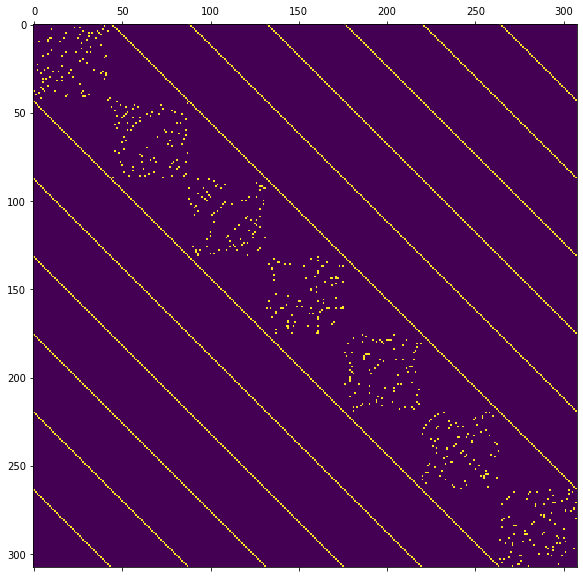

In [77]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(supra_mst['supra_mst_full_right'][:, :, 0]);
plt.show();

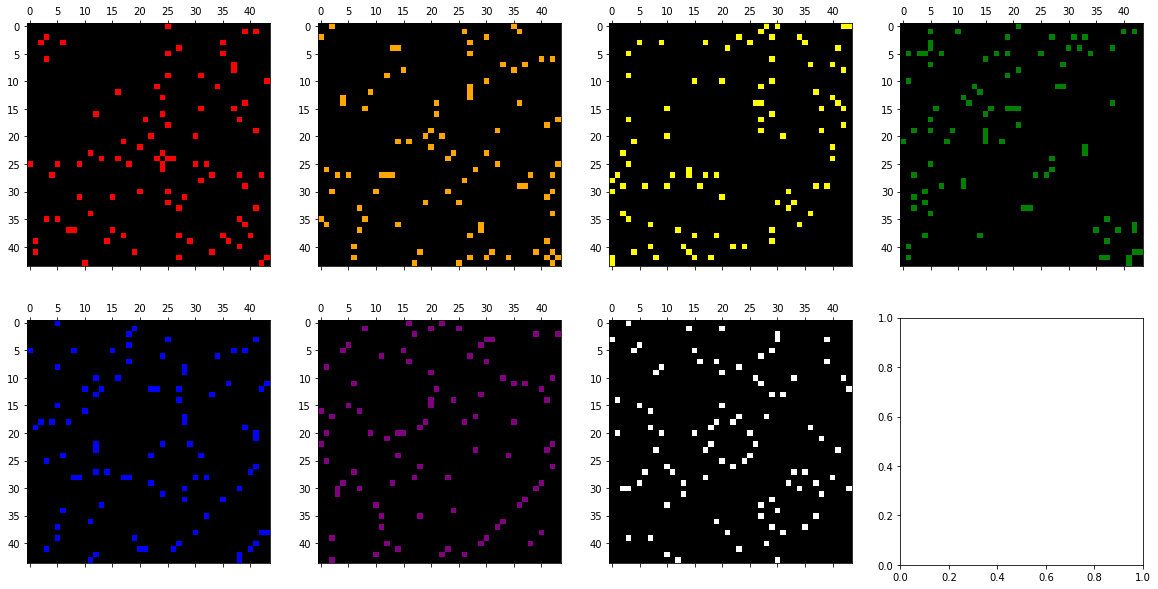

In [75]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

cmap00 = ListedColormap(['black', 'red'])
ax[0][0].matshow(supra_mst['supra_mst_full_left'][:44, :44, 0], cmap=cmap00);

cmap01 = ListedColormap(['black', 'orange'])
ax[0][1].matshow(supra_mst['supra_mst_full_left'][44:88, 44:88, 0], cmap=cmap01);

cmap02 = ListedColormap(['black', 'yellow'])
ax[0][2].matshow(supra_mst['supra_mst_full_left'][88:132, 88:132, 0], cmap=cmap02);

cmap03 = ListedColormap(['black', 'green'])
ax[0][3].matshow(supra_mst['supra_mst_full_left'][132:176, 132:176, 0], cmap=cmap03);

cmap10 = ListedColormap(['black', 'blue'])
ax[1][0].matshow(supra_mst['supra_mst_full_left'][176:220, 176:220, 0], cmap=cmap10);

cmap11 = ListedColormap(['black', 'purple'])
ax[1][1].matshow(supra_mst['supra_mst_full_left'][220:264, 220:264, 0], cmap=cmap11);

cmap12 = ListedColormap(['black', 'white'])
ax[1][2].matshow(supra_mst['supra_mst_full_left'][264:, 264:, 0], cmap=cmap12);
plt.show();

In [8]:
################################################################################################################################


# FROM THIS POINT FORWARD, NO FURTHER USER MODIFICATION/INPUT IS REQUIRED.
# This is where all of the functions are defined. None of these should require 
# modification or user input - only the last function, function_output, is needed
# for the user to calculate any multilayer network measure. Please also see the readme

###################################
# PREPARING THE MULTILAYER        #
###################################

def prepare_multilayer(data, list_of_layers, N=layer_size):
    """Converts the data to a Multinetx friendly object based on the inputed data.
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', '2= pli theta','5 = pli beta'
    list_of_layers = [0,1,2,5]
    
    Returns
    -------
    out : list of layers.    
    Note: This is convenient - since we can have a database with all 14 layers, but we may want to study only a smaller number of layers. 
    In short, the layers are based in the supra-adjacency matrices - but you can choose exactly the layers you want here"
    """
    
    
    #In the matlab file the element [-1] gives the matrices
    name = list(data.keys())[-1]
    if len(data[name].shape)==2:
        multilayer=np.expand_dims(data[name], axis=0).T
    else:
        multilayer = data[name]

    # Just checking if there are NaNs
    where_are_NaNs = np.isnan(multilayer)
    multilayer[where_are_NaNs] = 0
    #layer_size = 197 # This are the numbers of nodes in the layer
    #N = layer_size
    layer_list = list_of_layers

    layers=[]
    for i in layer_list:
        layers.append(multilayer[(i*N):(i+1)*N,(i*N):(i+1)*N,:])
        
    return layers


# This creates a multilayer network for each individual (This is the new one)
def multilayer_g(individual, data, list_of_single_layers, N=layer_size):
    """Creates a Multilayer graph object for an individual, given the data, and a list of layers.
    Parameters
    ----------
    
    Individual: an integer from [0, S-1], where S is the size of the cohort.
    
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta and pli theta, using the tags: 0=fmri', '1=pli delta', '2= pli theta'
    list_of_layers = [0,1,2]
    
    Returns
    -------
    out: A Multilayer Object for a single individual in the data.    
   
    """
    
    
    "Creates a multilayer for an individual i, knowing the number of layers, and the size of the layers"
    layers= prepare_multilayer(data, list_of_single_layers)
    #N =197 # before was 205
    number_of_layers=len(list_of_single_layers)
    G=[]
    for j in range(0,len(list_of_single_layers)):
        "j is running over all layers for a fixed individual i"
        G.append(nx.from_numpy_matrix(layers[j][:,:,individual])) #mx to nx
    
# Define the type of interconnection between the layers

# This creates the supra adjacency matrix
    adj_block = mx.lil_matrix(np.zeros((N*number_of_layers,N*number_of_layers))) # N is the size of the layer #mx to nx

# Need to create generic adjacency blocks!!!!

# These are generic interconnection blocks!!!   
    for i in range(number_of_layers):
        for j in range(number_of_layers):
            if i == j:
                adj_block[i*N:  (i+1)*N,  j*N:(j+1)*N] = np.zeros(N)
            else:
                adj_block[i*N:  (i+1)*N,  j*N:(j+1)*N] = np.identity(N)    

    mg = mx.MultilayerGraph(list_of_layers=G,inter_adjacency_matrix=adj_block)
    mg.set_edges_weights(intra_layer_edges_weight=1,inter_layer_edges_weight=1)

    return mg


#############################
# CREATING THE AGGREGATE    #
#############################
    
# ATTENTION: THERE ARE SEVERAL OPTIONS HERE - WE ARE USING A SIMILAR AGGREGATION AS MUXVIZ (see http://muxviz.net/tutorial.php)
# THIS IS AN INTERMEDIATE FUNCTION SO THAT THE OUTPUT OF THE OTHER FUNCTIONS IS PRINTED 'PER NODE'
def muxviz_aggregate(multiple_layers_list, number_layers):
    """Creates an aggregate output from a Multilayer Network, given a multiple_layers_list and the number of layers
    Parameters
    ----------
    
    multiple_layers_list: output of a multilayer network metric 
    
    number_layers: number of layers in the multilayer
    
    Returns
    -------
    out: An aggregate list which is the mean of the values of a Network property per node in each layer
   
    """
    k, m = divmod(len(multiple_layers_list), number_layers)
    temp = list(multiple_layers_list[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(number_layers))
    temp_mean = np.mean(temp,axis=0)
    temp_mean = temp_mean/max(temp_mean)
    #for sublists in temp:
    #    m=np.max(temp[sublists])
    #    for i in sublists:
    #        temp[sublists][i]=temp[sublists][i]/m
            
    return temp_mean


##########################################
# MULTILAYER NETWORK FUNCTIONS           #          
##########################################
    
# The strategy to create the functions is the same for every function; we can    
# parse all NetworkX functions here.            
    
def group_eigenvector_centrality(data, list_of_single_layers):
    """Returns a flat list with the muxviz_aggregate output for EC, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', '2= pli theta','5 = pli beta'
    list_of_layers = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the mean of the values of the EC per node in each layer
   
    """

    "This list will save all the eigenvector centralities for all individuals in all layers."
    name = list(data.keys())[-1]
    #fixed it!!! 
    if len(data[name].shape)==2:
        number_of_individuals=1
    else:
        number_of_individuals = data[name].shape[2]

    group_eigenvector = []
    for individual in range(number_of_individuals):
        temp = multilayer_g(individual,data,list_of_single_layers)

        m = mx.eigenvector_centrality_numpy(temp)
        #m=mx.eigenvector_centrality(multilayer_g(individual,number_of_layers,list_of_layers))
        temp1 = list(m.values())
        temp2 = muxviz_aggregate(temp1, len(list_of_single_layers)) 
        #temp2=aggregate(temp1,len(list_of_single_layers))
        # This is a list of lists with all centralities for all individuals
        group_eigenvector.append(temp2)
        # since we want to buid a flat list 
    flat_list = [item for sublist in group_eigenvector for item in sublist]
        
    return flat_list


def group_clustering(data, list_of_single_layers):
    """Returns a flat list with the aggregate output for group clustering, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', 
    '2= pli theta','5 = pli beta'
    list_of_layers = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the mean of the values of the Clustering per node in each layer
   
    """
    
    name = list(data.keys())[-1]
    if len(data[name].shape)==2:
        number_of_individuals=1
    else:
        number_of_individuals = data[name].shape[2]

    group_clustering = []
    for individual in range(number_of_individuals):
        temp = multilayer_g(individual, data, list_of_single_layers)

        m = mx.clustering(temp)
        temp1 = list(m.values())
        temp2 = muxviz_aggregate(temp1, len(list_of_single_layers)) 
        # This is a list of lists with all centralities for all individuals
        group_clustering.append(temp2)
    # We want to buid a flat list 
    # Check this flattened = [val for sublist in list_of_lists for val in sublist]
    flat_list = [item for sublist in group_clustering for item in sublist]
        
    return flat_list

   
def group_degree_centrality(data, list_of_single_layers):
    """Returns a flat list with the aggregate output for group degree centrality, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', 
    '2= pli theta','5 = pli beta'
    list_of_layers = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the mean of the values of the degree centrality per node in each layer
   
    """
    
    name = list(data.keys())[-1]
    if len(data[name].shape)==2:
        number_of_individuals=1
    else:
        number_of_individuals = data[name].shape[2]

    group_deg_centrality = []
    for individual in range(number_of_individuals):
        temp = multilayer_g(individual, data, list_of_single_layers)

        m = mx.degree_centrality(temp)
        
        temp1 = list(m.values())
        temp2 = muxviz_aggregate(temp1, len(list_of_single_layers)) 
        #temp2=aggregate(temp1,len(list_of_single_layers))
        # This is a list of lists with all centralities for all individuals
        group_deg_centrality.append(temp2)
        # since we want to buid a flat list 
    # Check this flattened = [val for sublist in list_of_lists for val in sublist]
    flat_list = [item for sublist in group_deg_centrality for item in sublist]
        
    return flat_list

    
def group_eccentricity(data, list_of_single_layers):
    """Returns a flat list with the aggregate output for group eccentricity, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', 
    '2= pli theta','5 = pli beta'
    list_of_layers = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the mean of the values of the eccentricity per node in each layer
   
    """
    
    name = list(data.keys())[-1]
    if len(data[name].shape)==2:
        number_of_individuals=1
    else:
        number_of_individuals = data[name].shape[2]

    group_eccentricity = []
    for individual in range(number_of_individuals):
        temp = multilayer_g(individual, data, list_of_single_layers)
        m = mx.eccentricity(temp)
        temp1 = list(m.values())
        temp2 = muxviz_aggregate(temp1, len(list_of_single_layers)) 
        # This is a list of lists with all eccentricities for all individuals
        group_eccentricity.append(temp2)
        # We want to buid a flat list 
    flat_list = [item for sublist in group_eccentricity for item in sublist]
        
    return flat_list


def non_norm_group_eccentricity(data, list_of_single_layers):
    """Returns a flat list with the aggregate output for group eccentricity without normalization, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', 
    '2= pli theta','5 = pli beta'
    list_of_layers = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the mean of the values of the eccentricity per node in each layer without normalization
   
    """
    name = list(data.keys())[-1]
    if len(data[name].shape)==2:
        number_of_individuals=1
    else:
        number_of_individuals = data[name].shape[2]

    group_eccentricity = []
    for individual in range(number_of_individuals):
        temp = multilayer_g(individual, data, list_of_single_layers)

        m = mx.eccentricity(temp)
        temp1 = list(m.values())
        temp2 = temp1 
        # For non normalized, we don't apply the muxviz_aggregate function
        #muxviz_aggregate(temp1, len(list_of_single_layers)) 
        
        #temp2=aggregate(temp1,len(list_of_single_layers))
        # This is a list of lists with all eccentricities for all individuals
        group_eccentricity.append(temp2)
        # since we want to buid a flat list 
    flat_list = [item for sublist in group_eccentricity for item in sublist]
        
    return flat_list

    
def group_bet_centrality(data, list_of_single_layers):
    """Returns a flat list with the aggregate output for group betweeness centralities, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', 
    '2= pli theta','5 = pli beta'
    list_of_layers = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the mean of the values of the betweeness centralities per node in each layer
   
    """
    
    name = list(data.keys())[-1]
    if len(data[name].shape)==2:
        number_of_individuals=1
    else:
        number_of_individuals = data[name].shape[2]

    group_bet_centrality = []
    for individual in range(number_of_individuals):
        temp = multilayer_g(individual,data,list_of_single_layers)

        m = mx.betweenness_centrality(temp)
        #m=mx.eigenvector_centrality(multilayer_g(individual,number_of_layers,list_of_layers))
        temp1 = list(m.values())
        temp2 = muxviz_aggregate(temp1, len(list_of_single_layers)) 
        #temp2=aggregate(temp1,len(list_of_single_layers))
        # This is a list of lists with all centralities for all individuals
        group_bet_centrality.append(temp2)
        # We want to buid a flat list 
    # Check this flattened = [val for sublist in list_of_lists for val in sublist]
    flat_list = [item for sublist in group_bet_centrality for item in sublist]
        
    return flat_list


# The functions below calculate mean and standard deviation of the measures
    
def group_eigenvector_centrality_mean(data, list_of_single_layers):
    """Returns a flat list with the aggregate output for group eigenvector centrality mean, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', 
    '2= pli theta','5 = pli beta'
    list_of_layers = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the mean of the values of the eigenvector centralities per node in each layer
   
    """
    
    "This function returns the group eigenvector centrality mean for all individuals"
    name = list(data.keys())[-1]
    if len(data[name].shape)==2:
        number_of_individuals=1
    else:
        number_of_individuals = data[name].shape[2]

    group_eigenvector_mean = []
    for individual in range(number_of_individuals):
        temp = multilayer_g(individual, data, list_of_single_layers)

        m = mx.eigenvector_centrality_numpy(temp)
        temp1 = list(m.values())
        temp2 = muxviz_aggregate(temp1, len(list_of_single_layers)) 
        # Now we just compute the mean
        group_eigenvector_mean.append(np.mean(temp2))
        
    return (group_eigenvector_mean)


def group_eigenvector_centrality_std(data, list_of_single_layers):
    """Returns a flat list with the aggregate output for group eigenvector centrality standard deviation, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', 
    '2= pli theta','5 = pli beta'
    list_of_layers = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the standard deviation of the eigenvector centralities per subject
   
    """
    
    "This function returns the group eigenvector centrality standard deviation for all individuals"
    
    name = list(data.keys())[-1]
    if len(data[name].shape)==2:
        number_of_individuals=1

    else:
        number_of_individuals = data[name].shape[2]
    group_eigenvector_std = []
    for individual in range(number_of_individuals):
        temp = multilayer_g(individual, data, list_of_single_layers)
        m = mx.eigenvector_centrality_numpy(temp)
        #m=mx.eigenvector_centrality(multilayer_g(individual,number_of_layers,list_of_layers))
        temp1 = list(m.values())
        temp2 = muxviz_aggregate(temp1, len(list_of_single_layers)) 
        # This is MV aggregate - we can change then later for something else if needed
        
        group_eigenvector_std.append(np.std(temp2))
        
    return (group_eigenvector_std)


def eigenvector_centrality(individual, data, list_of_single_layers):
    """Returns a histogram with the values of the Eigenvector centrality for all nodes for a chosen individual."
    Parameters
    ----------
    individual: an integer from [0, S-1], where S is the size of the cohort.
        
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta and pli theta, using the tags: 0=fmri', '1=pli delta', '2= pli theta'
    list_of_layers = [0,1,2]
    
    Returns
    -------
    out: A list with EC for one individual
   
    """
    print('layers =',[layer_tags[i] for i in list_of_single_layers])
    m = mx.eigenvector_centrality_numpy(multilayer_g(individual, data, list_of_single_layers))
    temp1 = list(m.values())
    temp2=muxviz_aggregate(temp1,len(list_of_single_layers))
   
    return temp2


def group_degree_centrality_mean(data,list_of_single_layers):
     """Returns a flat list with the aggregate output for group degree centrality mean, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', 
    '2= pli theta','5 = pli beta'
    list_of_single_layers  = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the mean of the values of the degree centralities per node in each layer
   
    """
    
#    "This function returns the group degree centrality mean for all individuals"
    
     print('layers =',[layer_tags[i] for i in list_of_single_layers])
     name = list(data.keys())[-1]
     if len(data[name].shape)==2:
            number_of_individuals=1
     else:
        number_of_individuals = data[name].shape[2]

#     "This list will save all the eigenvector centralities means for all individuals"
     group_degree_centrality_mean = []
     for individual in range(number_of_individuals):
         m = mx.degree_centrality(multilayer_g(individual,data,list_of_single_layers))
         temp1 = list(m.values()) # this is not aggregated 
         temp2 = muxviz_aggregate(temp1, len(list_of_single_layers)) # This is Mux Viz aggregate
        #temp2=aggregate(temp1,len(list_of_single_layers))
        # IF you want - by any chance to do a different agreggate you should change the line above
         group_degree_centrality_mean.append(np.mean(temp2))
         
     return (group_degree_centrality_mean)


def group_degree_centrality_std(data, list_of_single_layers):
    """Returns a flat list with the aggregate output for group degree centrality std, given a data, and a list_of_single_layers
    
    Parameters
    ----------
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta, pli theta, and pli beta using the tags: 0=fmri', '1=pli delta', 
    '2= pli theta','5 = pli beta'
    list_of_single_layers = [0,1,2,5]
    
    Returns
    -------
    out: An aggregate list which is the standard deviation of the values of the betweeness centralities per subject
   
    """
    print('layers =',[layer_tags[i] for i in list_of_single_layers])
    name = list(data.keys())[-1]
    if len(data[name].shape)==2:
        number_of_individuals=1
    else:
        number_of_individuals = data[name].shape[2]
    "This list will save all the eigenvector centralities means for all individuals"
    group_degree_centrality_std = []
    for individual in range(number_of_individuals):
        m = mx.degree_centrality(multilayer_g(individual, data, list_of_single_layers))
        temp1 = list(m.values())
        temp2 = muxviz_aggregate(temp1, len(list_of_single_layers))  # This is Mux Viz aggregate
        #temp2=aggregate(temp1,len(list_of_single_layers)) You can change the aggregate here
        print(temp2)
        group_degree_centrality_std.append(np.std(temp2))
        
    return (group_degree_centrality_std)


######################
# PLOTTING FUNCTIONS # 
######################

def plot_group_ec(data, list_of_single_layers):
    """Returns a histogram plot with the values of the Eigenvalue centrality for all nodes across all individuals."
    Parameters
    ----------
        
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta and pli theta, using the tags: 0=fmri', '1=pli delta', '2= pli theta'
    list_of_layers = [0,1,2]
    
    Returns
    -------
    out : A histogram plot with EC for all nodes across all individuals
   
    """
    
    print('layers =',[layer_tags[i] for i in list_of_single_layers])

    temp = group_eigenvector_centrality(data,list_of_single_layers)
    plt.figure(figsize=(8,5))
    plt.hist(temp)
    # We can edit here the output if we have a vector with the name of the layers
    plt.xlabel('Eig. centr. - aggr- all nodes all individuals ', fontsize=20)
    #plt.xlim(-5,220)
    plt.ylabel("frequence", fontsize=20)
    #plt.xlim(40, 160)
    plt.ylim(0, 3500)
    #plt.title('individual '+str(individual))
    plt.show()


def plot_ec(individual, data, list_of_single_layers):
    """Returns a histogram with the values of the Eigenvalue centrality for all nodes for a chosen individual."
    Parameters
    ----------
    individual: an integer from [0, S-1], where S is the size of the cohort.
        
    data : A preloaded .mat  - Ex: supra_mst
    
    
    list_of_layers: a list of numbers corresponding to the Multilayer you want to create - 
    Ex: If you want a Multilayer with fmri, pli_delta and pli theta, using the tags: 0=fmri', '1=pli delta', '2= pli theta'
    list_of_layers = [0,1,2]
    
    Returns
    -------
    out: A histogram with EC for one individual
   
    """
    
    print('layers =',[layer_tags[i] for i in list_of_single_layers])
    #multilayer_g(individual,data,list_of_single_layers)
    m = mx.eigenvector_centrality_numpy(multilayer_g(individual,data,list_of_single_layers))
    #temp=multlayer3(i)
    temp1 = list(m.values())
    temp2 = muxviz_aggregate(temp1, len(list_of_single_layers)) 
    # This is the Mux Viz aggregate - We change the aggregate here if yo want later
    plt.hist((temp2))
    ###IMPROVEMENT: We can edit here the output if we have a vector with the name of the layers
    plt.xlabel('Eigenvector centrality - aggregate ', fontsize=20)
    #We may also want to choose the range for the plot.
    #plt.xlim(min,max)
    plt.ylabel("frequence", fontsize=20)
    plt.ylim(0, 100)
    plt.title('individual '+ str(individual))
    plt.show()
    return
             

###################
# OTHER FUNCTIONS #
###################
    
# This function extracts data from specific nodes - e.g. FPN or DMN
#### IMPROVEMENT: ALSO COMPUTE MEASURES WITHIN SPECIFIC SUBNETWORK IN THE FUTURE
def mask_subnetwork(result, target):
    """Returns a multilayer metric narrowed for a given list of nodes, which for our purposes are subnetworks""
    
    Parameters
    ----------
    result: A list with the results (output) of any of Multilayer functions in this code
    
    target : A list of target nodes of interest, e.g., nodes from DFN or FPN
    
    Returns
    -------
    out: A list for the results narrowed for the target nodes, i.e., If you say the target nodes for a given subnetwork, this function returns only the results of the list associated with the target nodes"
    """

    chunks = [result[x:x+layer_size] for x in range(0, len(result), layer_size)]
    mask = [chunk[x] for chunk in chunks for x in target]
    
    return mask


# This function saves data to a csv file
def save_csv(data, name, tag):
    """Returns a .csv file for further analysis using SPSS
    Parameters
    ----------
    data: The desired data you want to save
    name: The name of the file you want to save
    tag: The tag for the variable/column in your .csv file
    """
    # Obs: Notice that if you want to get results only for a subnetwork, we should first do:
    #data=mask_subnetwork(result,target)
    #before saving this file
    cols = [tag]
    df = pd.DataFrame(data, columns=cols)
    df.to_csv(name+'.csv')
    
    return

# ATTENTION: THIS IS THE ONLY FUNCTION THAT THE USER NEEDS TO CALCULATE ANY MULTILAYER
# NETWORK MEASURE
### IMPROVEMENT: create a boolean that does stuff when a mask is chosen or not
def function_output(function, data, filename, colname, layers, N=layer_size):
    """Returns the desired output for the MumoBrain database, or any other database organized similarly
    
    THIS IS PROBABLY THE MOST IMPORTANT FUNCTION FOR THE USER OF THIS CODE, SINCE EVERYTHING WAS BUILT TO REACH THIS STAGE HERE
    
    Parameters
    ----------
    function: One of the functions developed in this code for Multilayer Networks
    data: The data we want to use: e.g., supra_mst
    filename: The name of the file you want to save
    colname: the name of the column tag in your file
    layers: list of desired layers.

    """
    temp = function(data, layers)
    #You should include the desired subnetwork here. Now we have the whole Network.
    sub_net = list(range(0,N)) 
    # Ex: If you want FPN, sub_net=[16,17,18,19,20,21,28,29,30,31,93,94,123,124,133,134,163,164]
    
    temp_sub_net = mask_subnetwork(temp, sub_net)
    save_csv(temp_sub_net, filename, colname)
    
    return

# Right

In [78]:
function_output(group_eigenvector_centrality, supra_mst, 'brainhack_data/output/EC_Multi_layer_full_right', 'EC_Multi_layer_full_right', [0,1,2,3,4,5,6])
function_output(group_eigenvector_centrality, supra_mst, 'brainhack_data/output/EC_Multi_layer_EEG_right', 'EC_Multi_layer_EEG_right', [0,1,2,3,4])
function_output(group_eigenvector_centrality, supra_mst, 'brainhack_data/output/EC_Multi_layer_fNIRS_right', 'EC_Multi_layer_fNIRS_right', [5,6])

In [79]:
output = np.genfromtxt('brainhack_data/output/EC_Multi_layer_fNIRS_right.csv', delimiter=',')
reshaped = output[1:,1].reshape(22, 44)
df = pd.DataFrame(reshaped)
df.to_csv('brainhack_data/output/EC_Multi_layer_fNIRS_right_reshaped.csv')

In [ ]:
just_tags=['pli_delta', 'pli_theta', 'pli_alpha', 'pli_beta', 'pli_gamma', 'hbo', 'hbr']

for i, mod in enumerate(just_tags):
    function_output(group_eigenvector_centrality, supra_mst, 'brainhack_data/output/layers/EC_Multi_layer_right_'+mod, 'EC_Multi_layer_right_'+mod, [i])

In [ ]:
for i, mod in enumerate(just_tags):
    output = np.genfromtxt('brainhack_data/output/layers/EC_Multi_layer_right_'+mod+'.csv', delimiter=',')
    reshaped = output[1:,1].reshape(22, 44)
    df = pd.DataFrame(reshaped)
    df.to_csv('brainhack_data/output/layers/EC_Multi_layer_right_'+mod+'_reshaped.csv')

In [14]:
full = pd.read_csv('brainhack_data/output/EC_Multi_layer_full_right_reshaped.csv', index_col=0)
full_mean = full.mean()

eeg = pd.read_csv('brainhack_data/output/EC_Multi_layer_EEG_right_reshaped.csv', index_col=0)
eeg_mean = eeg.mean()

fnirs = pd.read_csv('brainhack_data/output/EC_Multi_layer_fNIRS_right_reshaped.csv', index_col=0)
fnirs_mean = fnirs.mean()

pli_delta = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_right_pli_delta_reshaped.csv', index_col=0)
pli_delta_mean = pli_delta.mean()

pli_theta = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_right_pli_theta_reshaped.csv', index_col=0)
pli_theta_mean = pli_theta.mean()

pli_alpha = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_right_pli_alpha_reshaped.csv', index_col=0)
pli_alpha_mean = pli_alpha.mean()

pli_beta = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_right_pli_beta_reshaped.csv', index_col=0)
pli_beta_mean = pli_beta.mean()

pli_gamma = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_right_pli_gamma_reshaped.csv', index_col=0)
pli_gamma_mean = pli_gamma.mean()

hbo = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_right_hbo_reshaped.csv', index_col=0)
hbo_mean = hbo.mean()

hbr = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_right_hbr_reshaped.csv', index_col=0)
hbr_mean = hbr.mean()

In [15]:
right_df = pd.DataFrame({'Full': full_mean, 'EEG': eeg_mean, 'fNIRS': fnirs_mean, 'Pli delta': pli_delta_mean, 'Pli theta': pli_theta_mean,
                         'Pli alpha': pli_alpha_mean, 'Pli beta': pli_beta_mean, 'Pli gamma': pli_gamma_mean, 'HbO': hbo_mean, 'HbR': hbr_mean})

In [35]:
right_df.to_csv('EC_right.csv')

# Left

In [ ]:
function_output(group_eigenvector_centrality, supra_mst, 'brainhack_data/output/EC_Multi_layer_full_left', 'EC_Multi_layer_full_left', [0,1,2,3,4,5,6])
function_output(group_eigenvector_centrality, supra_mst, 'brainhack_data/output/EC_Multi_layer_EEG_left', 'EC_Multi_layer_EEG_left', [0,1,2,3,4])
function_output(group_eigenvector_centrality, supra_mst, 'brainhack_data/output/EC_Multi_layer_fNIRS_left', 'EC_Multi_layer_fNIRS_left', [5,6])

In [ ]:
output = np.genfromtxt('brainhack_data/output/EC_Multi_layer_fNIRS_left.csv', delimiter=',')
reshaped = output[1:,1].reshape(22, 44)
df = pd.DataFrame(reshaped)
df.to_csv('brainhack_data/output/EC_Multi_layer_fNIRS_left_reshaped.csv')

In [ ]:
just_tags=['pli_delta', 'pli_theta', 'pli_alpha', 'pli_beta', 'pli_gamma', 'hbo', 'hbr']

for i, mod in enumerate(just_tags):
    function_output(group_eigenvector_centrality, supra_mst, 'brainhack_data/output/layers/EC_Multi_layer_left_'+mod, 'EC_Multi_layer_left_'+mod, [i])

In [ ]:
for i, mod in enumerate(just_tags):
    output = np.genfromtxt('brainhack_data/output/layers/EC_Multi_layer_left_'+mod+'.csv', delimiter=',')
    reshaped = output[1:,1].reshape(22, 44)
    df = pd.DataFrame(reshaped)
    df.to_csv('brainhack_data/output/layers/EC_Multi_layer_left_'+mod+'_reshaped.csv')

In [31]:
full = pd.read_csv('brainhack_data/output/EC_Multi_layer_full_left_reshaped.csv', index_col=0)
full_mean = full.mean()

eeg = pd.read_csv('brainhack_data/output/EC_Multi_layer_EEG_left_reshaped.csv', index_col=0)
eeg_mean = eeg.mean()

fnirs = pd.read_csv('brainhack_data/output/EC_Multi_layer_fNIRS_left_reshaped.csv', index_col=0)
fnirs_mean = fnirs.mean()

pli_delta = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_left_pli_delta_reshaped.csv', index_col=0)
pli_delta_mean = pli_delta.mean()

pli_theta = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_left_pli_theta_reshaped.csv', index_col=0)
pli_theta_mean = pli_theta.mean()

pli_alpha = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_left_pli_alpha_reshaped.csv', index_col=0)
pli_alpha_mean = pli_alpha.mean()

pli_beta = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_left_pli_beta_reshaped.csv', index_col=0)
pli_beta_mean = pli_beta.mean()

pli_gamma = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_left_pli_gamma_reshaped.csv', index_col=0)
pli_gamma_mean = pli_gamma.mean()

hbo = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_left_hbo_reshaped.csv', index_col=0)
hbo_mean = hbo.mean()

hbr = pd.read_csv('brainhack_data/output/layers/EC_Multi_layer_left_hbr_reshaped.csv', index_col=0)
hbr_mean = hbr.mean()

In [32]:
left_df = pd.DataFrame({'Full': full_mean, 'EEG': eeg_mean, 'fNIRS': fnirs_mean, 'Pli delta': pli_delta_mean, 'Pli theta': pli_theta_mean,
                         'Pli alpha': pli_alpha_mean, 'Pli beta': pli_beta_mean, 'Pli gamma': pli_gamma_mean, 'HbO': hbo_mean, 'HbR': hbr_mean})

In [34]:
left_df.to_csv('EC_left.csv')

# Results

In [51]:
import seaborn as sns
%matplotlib inline

left_corr = left_df.corr()

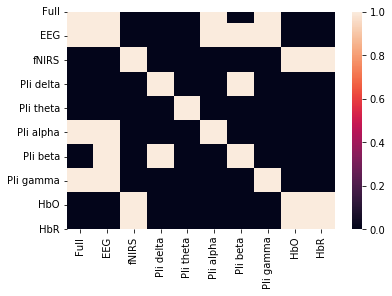

In [50]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=left_df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in left_df.columns:
        for c in left_df.columns:
            tmp = left_df[left_df[r].notnull() & left_df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

left_p = calculate_pvalues(left_df) < 0.05

sns.heatmap(left_p, 
        xticklabels=left_p.columns,
        yticklabels=left_p.columns);

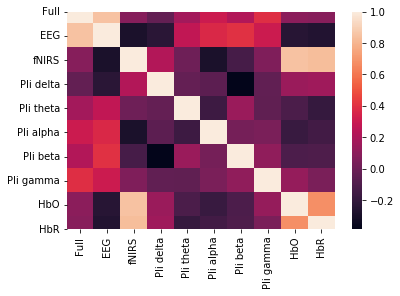

In [52]:
sns.heatmap(left_corr, 
        xticklabels=left_corr.columns,
        yticklabels=left_corr.columns);

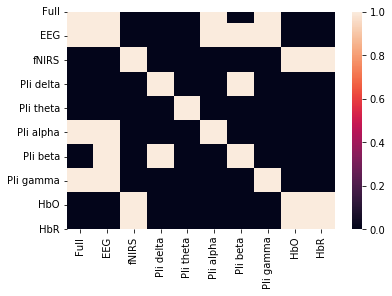

In [55]:
right_p = calculate_pvalues(right_df) < 0.05

sns.heatmap(right_p, 
        xticklabels=right_p.columns,
        yticklabels=right_p.columns);

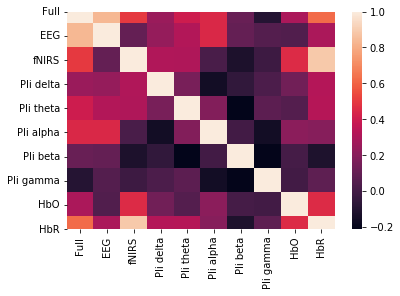

In [40]:
right_corr = right_df.corr()

sns.heatmap(right_corr, 
        xticklabels=left_corr.columns,
        yticklabels=left_corr.columns);